In [19]:
import sys
import os

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add parent directory to sys.path
sys.path.append(parent_dir)

print(parent_dir)

/home/adam/dev/gradual-aacbr/examples


In [20]:
import torch
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

import deeparguing.feature_extractor.feature_weighted_extractor as fwe
import deeparguing.feature_extractor.mlp_extractor as mlpe

from helper import load_glioma, split_data, normalise_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
SEED = 42

In [23]:
X, y = load_glioma(exclude_non_binary_features=True)


train_full, train, val, test = split_data(X, y, SEED)

print(f"Test Size:  {len(test['X'])}")
print(f"Train Size:  {len(train['X'])}")
print(f"Validation Size:  {len(val['X'])}")

Test Size:  168
Train Size:  536
Validation Size:  135


In [24]:
X_train_full, y_train_full = torch.tensor(train_full["X"], device=device),      torch.tensor(train_full["y"], dtype=torch.float32, device=device)
X_train, y_train           = torch.tensor(train["X"]     , device=device),      torch.tensor(train["y"],      dtype=torch.float32, device=device)
X_val, y_val               = torch.tensor(val["X"]       , device=device),      torch.tensor(val["y"],        dtype=torch.float32, device=device)
X_test, y_test             = torch.tensor(test["X"]      , device=device),      torch.tensor(test["y"],       dtype=torch.float32, device=device)

In [25]:
train_mean = X_train.mean(dim=0)
train_std = X_train.std(dim=0) 

X_train = normalise_input(X_train, train_mean, train_std)
X_val = normalise_input(X_val, train_mean, train_std)
X_test = normalise_input(X_test, train_mean, train_std)

In [26]:
EPOCHS = 500
LR = 2e-2
torch_seed = 0
torch.manual_seed(torch_seed) 

In [27]:
no_features = X_train.shape[-1]

model = mlpe.MLPExtractor(no_features, [], 2).to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [28]:
def eval_model(model, X, y):
    # Assess the model pre-training
    with torch.no_grad():
        y_preds = torch.argmax(model(X), dim=1).cpu().detach().numpy()
        y_actual = torch.argmax(y, dim=1).cpu().numpy()

        # print("predictions", y_preds)
        # print("actuals", y_actual)

        results = ( 
            accuracy_score(y_actual, y_preds),
            precision_score(y_actual, y_preds, average='macro', zero_division=0),
            recall_score(y_actual, y_preds, average='macro', zero_division=0),
            f1_score(y_actual, y_preds, average='macro', zero_division=0),
            confusion_matrix(y_actual, y_preds)
        )


        print("Accuracy, precision, recall, f1")
        print(results[:-1])
        print("confusion matrix:")
        print(results[-1])

In [29]:
losses = np.zeros((EPOCHS))
for epoch in range(EPOCHS):

    optimizer.zero_grad()
    y_preds = model(X_train)
    loss = criterion(y_preds, y_train)
    loss.backward()
    losses[epoch] = loss.item()
    optimizer.step()

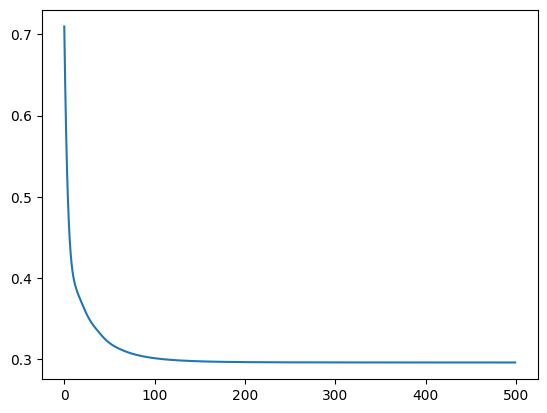

In [30]:
plt.plot(losses)
plt.show()

In [31]:
print("TRAINING SET")
eval_model(model, X_train, y_train)

TRAINING SET
Accuracy, precision, recall, f1
(0.8880597014925373, np.float64(0.8858258928571429), np.float64(0.8921279491833031), np.float64(0.8871547271502358))
confusion matrix:
[[262  42]
 [ 18 214]]


In [32]:
print("VALIDATION SET")
eval_model(model, X_val, y_val)

VALIDATION SET
Accuracy, precision, recall, f1
(0.837037037037037, np.float64(0.8173505798394292), np.float64(0.8692267773741567), np.float64(0.8252941176470588))
confusion matrix:
[[74 20]
 [ 2 39]]


In [33]:
print("TEST SET")
eval_model(model, X_test, y_test)

TEST SET
Accuracy, precision, recall, f1
(0.8511904761904762, np.float64(0.8572654462242563), np.float64(0.8552837434219884), np.float64(0.8511430090377459))
confusion matrix:
[[70 19]
 [ 6 73]]
